In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from scipy import signal, stats, optimize
from fractal_deriv import *
from observer import kfilter

'''x_file = './roboao_tt/lx_all_library.txt'
y_file = './roboao_tt/ly_all_library.txt'
x_tt, y_tt = (np.genfromtxt(file).flatten() * 0.0175797 * 2 for file in (x_file, y_file))'''
x_tt = np.load('./turbulence_86.npy')[:,0]

In [2]:
f_sampling = 8.6
N = 500
lim = 1000

(1e-07, 2.4265424397306115)

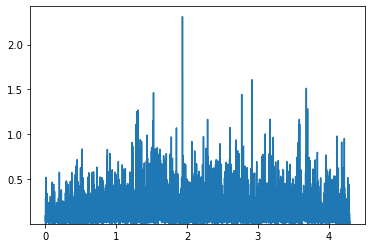

In [3]:
plt.plot(*signal.periodogram(x_tt, fs=f_sampling))
plt.ylim(1e-7)

/usr/local/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/adityasengupta/projects/adaptive-optics/control/dev/fractal_deriv.py:140: ComplexWarning: Casting complex values to real discards the imaginary part
  y[k] = np.sum(u[range(k,k-L,-1)]*a[0:L])


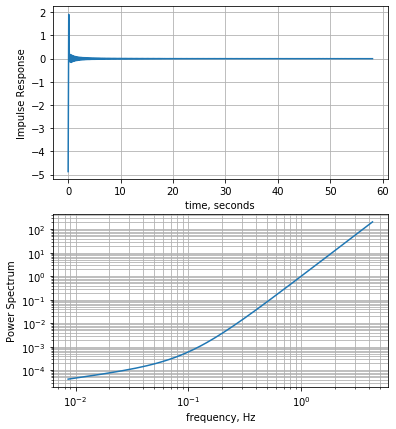

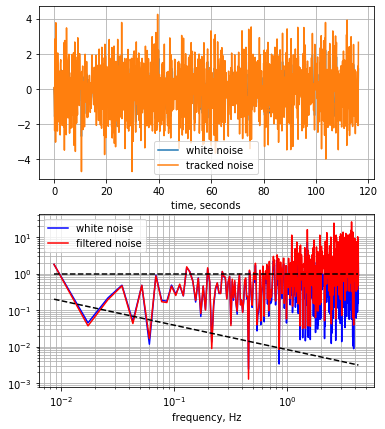

In [4]:
filter_turbulence = design_filt(dt = 1/f_sampling, N = 2*N) 
# the good thing about Robo-AO frequency being so low 
# is I can drive N really low and match it
response = filt(filter_turbulence, dt=1/f_sampling, u=x_tt[:lim])
# I'm worried about overfitting right now, but let's try and ignore that and instead just translate this to SS

In [5]:
def make_impulse_filter(x):
    # takes in np array x: the impulse response of a filter
    # returns matrices A, P, Q, H, R to augment with the kfilter
    n = x.size
    A = np.zeros((n, n))
    for i in range(1, n):
        A[i][i-1] = 1
    A[0] = np.flip(x)
    # when you start the filter, make sure to start it at time n with the first n measurements identically
    P = np.zeros((n,n))
    Q = np.zeros((n,n))
    Q[0][0] = 1
    H = np.zeros((1,n))
    H[:,0] = 1
    R = np.array([0.04**2])
    return A, P, Q, H, R

A, P, Q, H, R = make_impulse_filter(filter_turbulence)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  


In [6]:
# now, let's Kalman filter with this
measurements = x_tt + np.random.normal(0, 0.04, x_tt.shape)
rms = lambda data: np.sqrt(np.mean(data ** 2))
kfiltered = kfilter((measurements[:N], A, P, Q, H, R), measurements[N:lim])

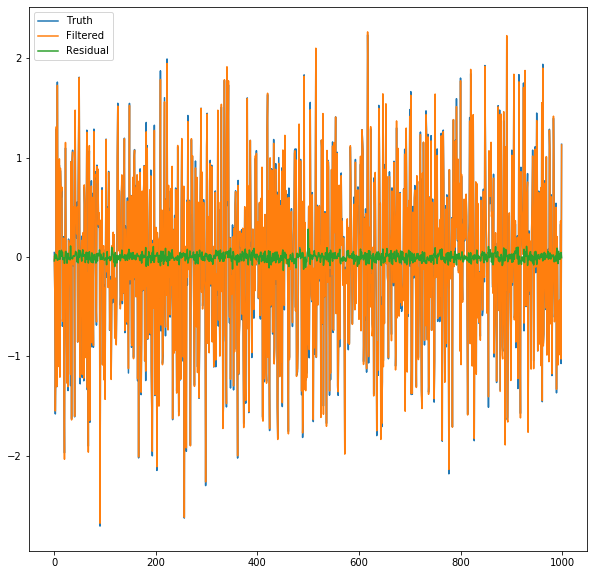

In [7]:
plt.figure(figsize=(10,10))
filtered = np.hstack((measurements[:N], kfiltered))
plt.plot(x_tt[:lim], label='Truth')
plt.plot(filtered, label='Filtered')
residual = filtered - x_tt[:lim]
plt.plot(residual, label='Residual')
plt.legend()

In [8]:
rms(residual[:])

0.0411521348510125

Okay, this is bad - seems like the Kalman filter can't actually get rid of any of the measurement noise.

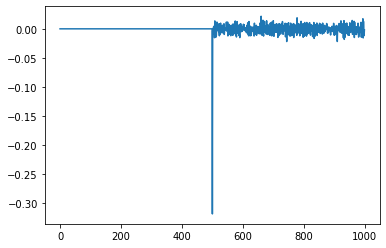

In [9]:
# the 'are you just tracking measurements' plot
plt.plot(measurements[:lim] - filtered[:lim])